In [3]:
!pip install opencv-python -q

Number of Monet paintings: 300
Number of photo images: 7038


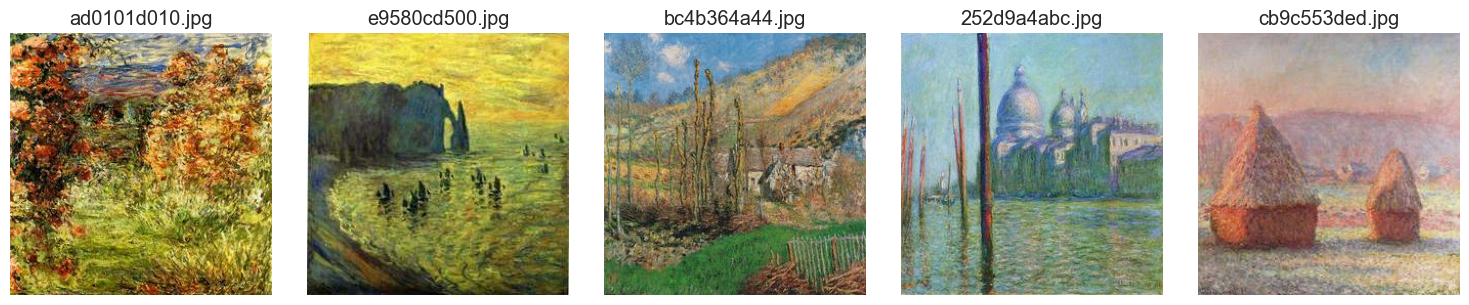

Sample Monet Paintings


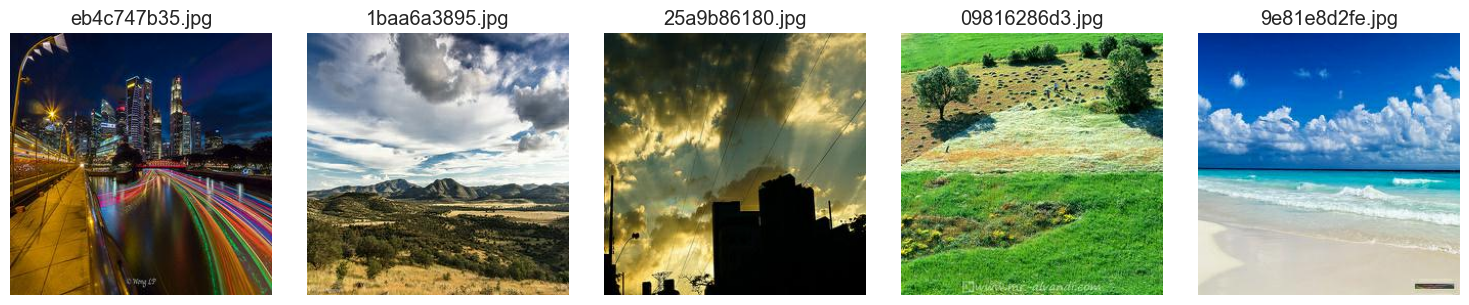

Sample Photos

Monet Image Shapes:
  - (256, 256, 3): 300 images (100.00%)

Photo Image Shapes:
  - (256, 256, 3): 7038 images (100.00%)


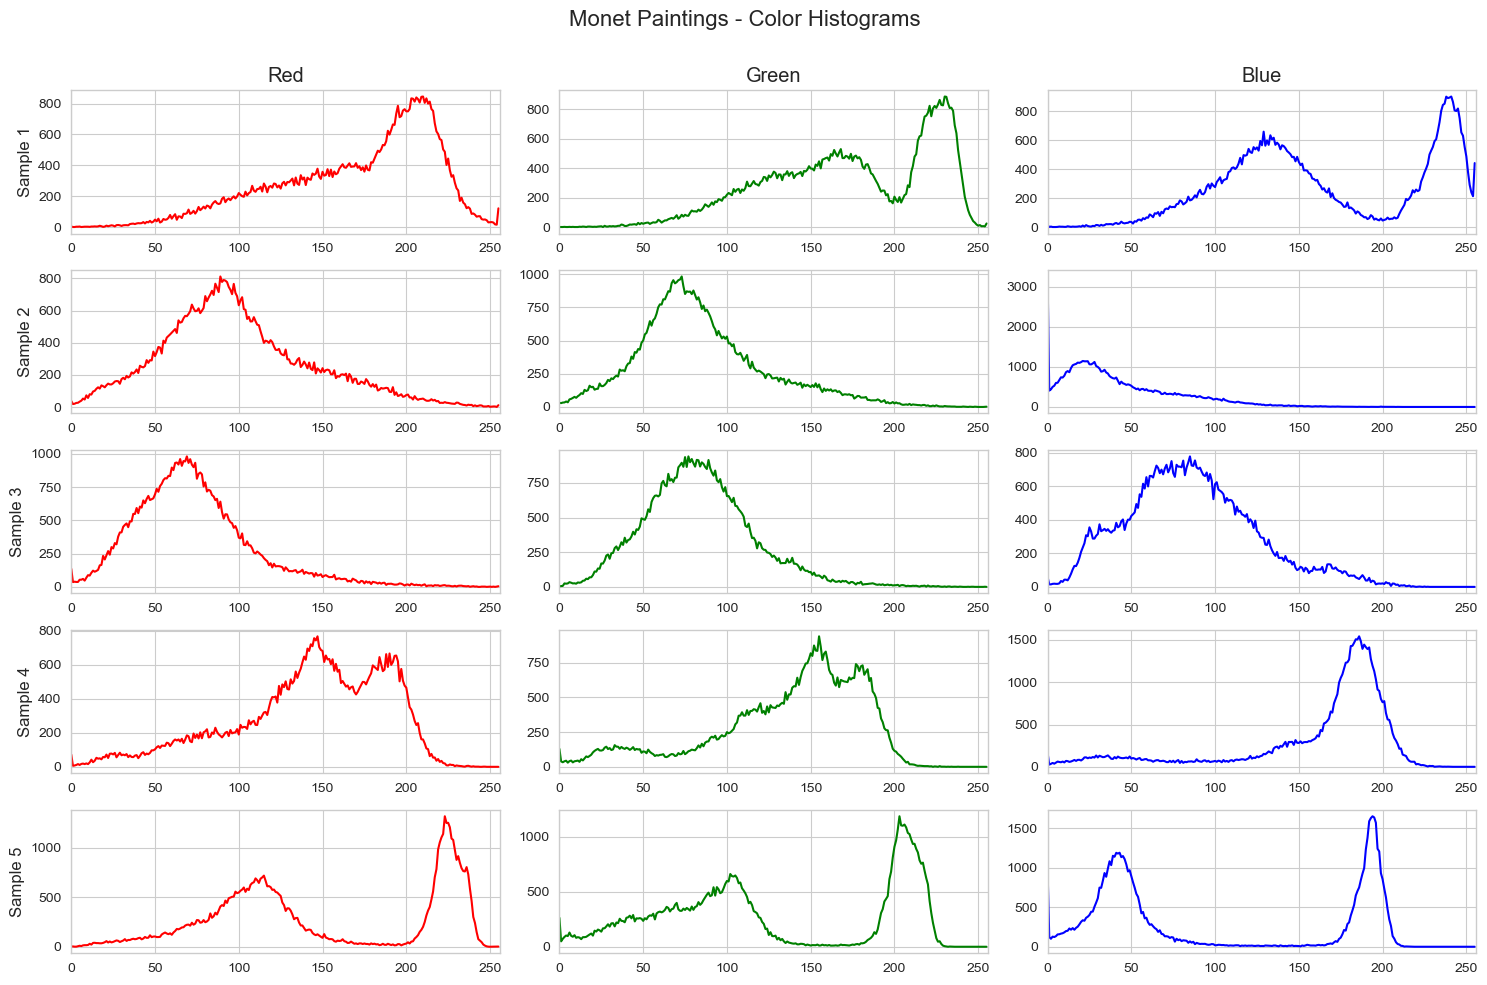

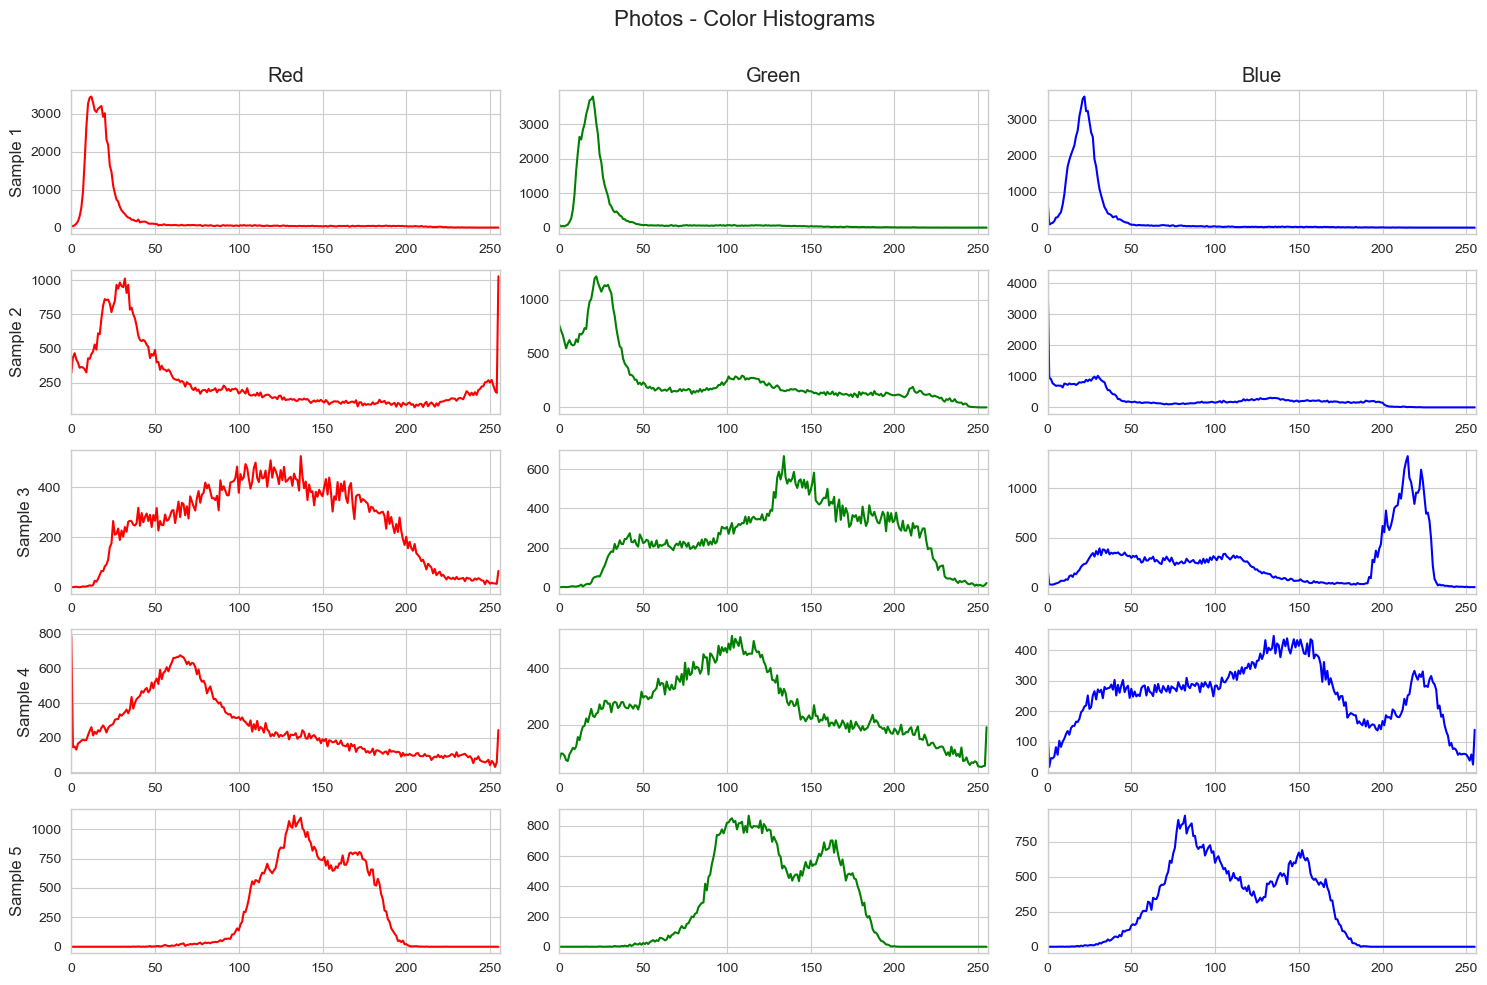

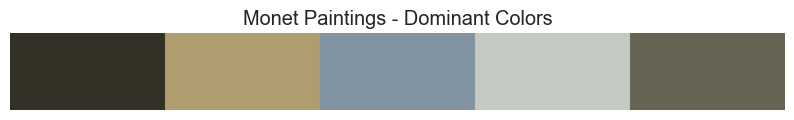

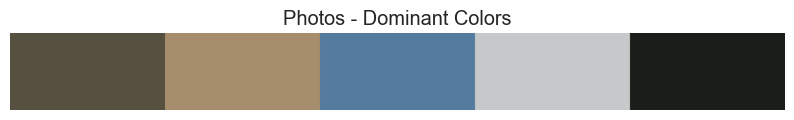

Extracting features for a subset of images using InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Applying PCA for dimension reduction...


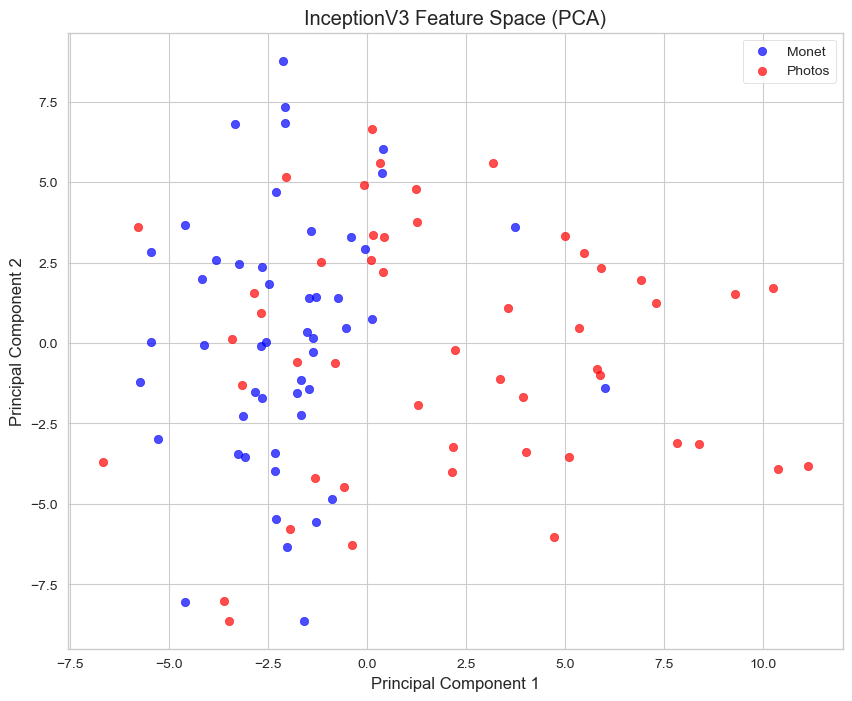

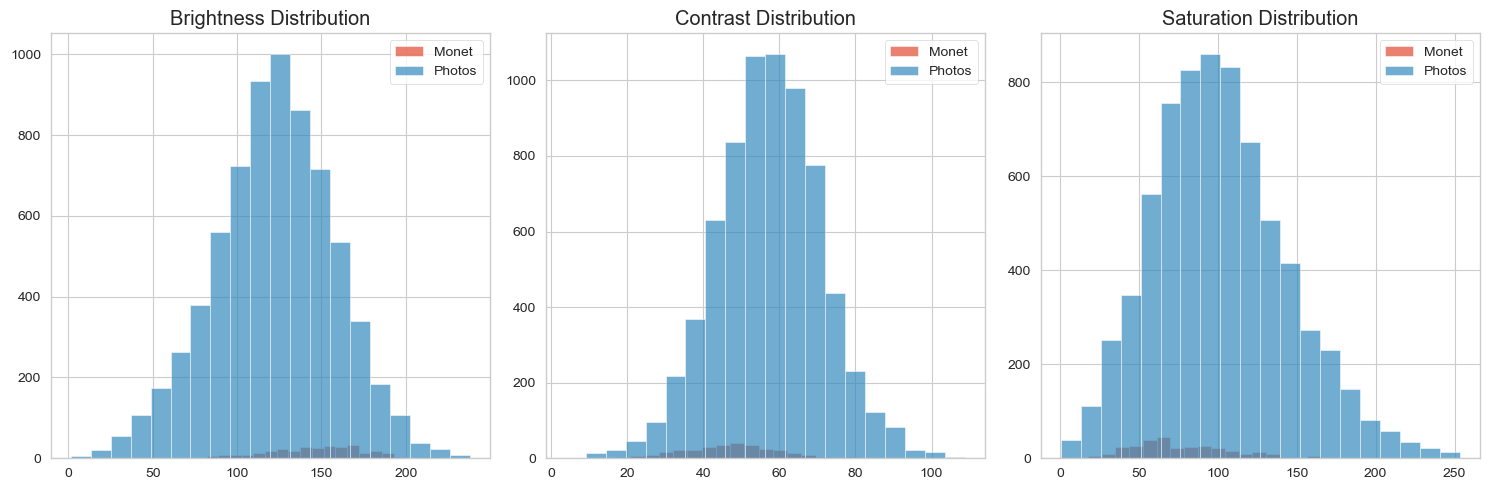

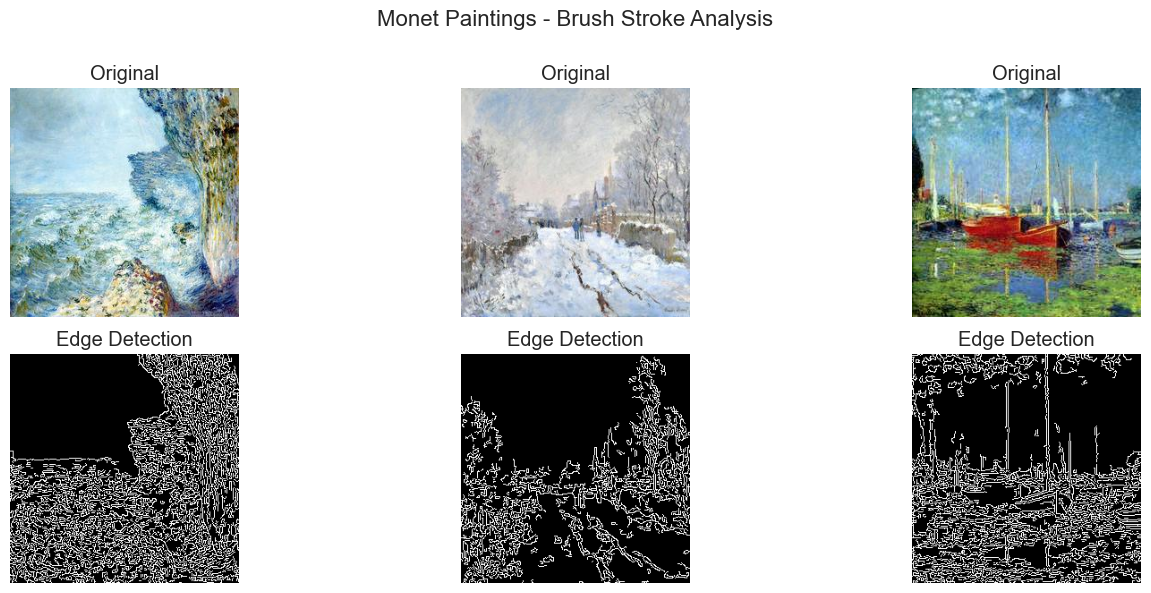

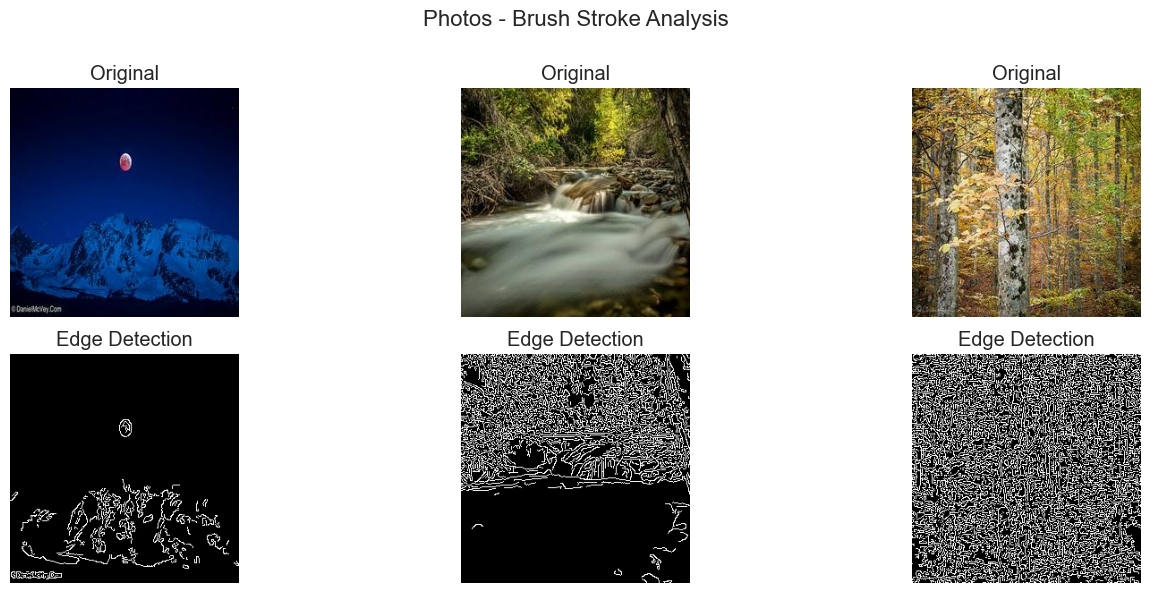

Analyzing Monet paintings color composition:


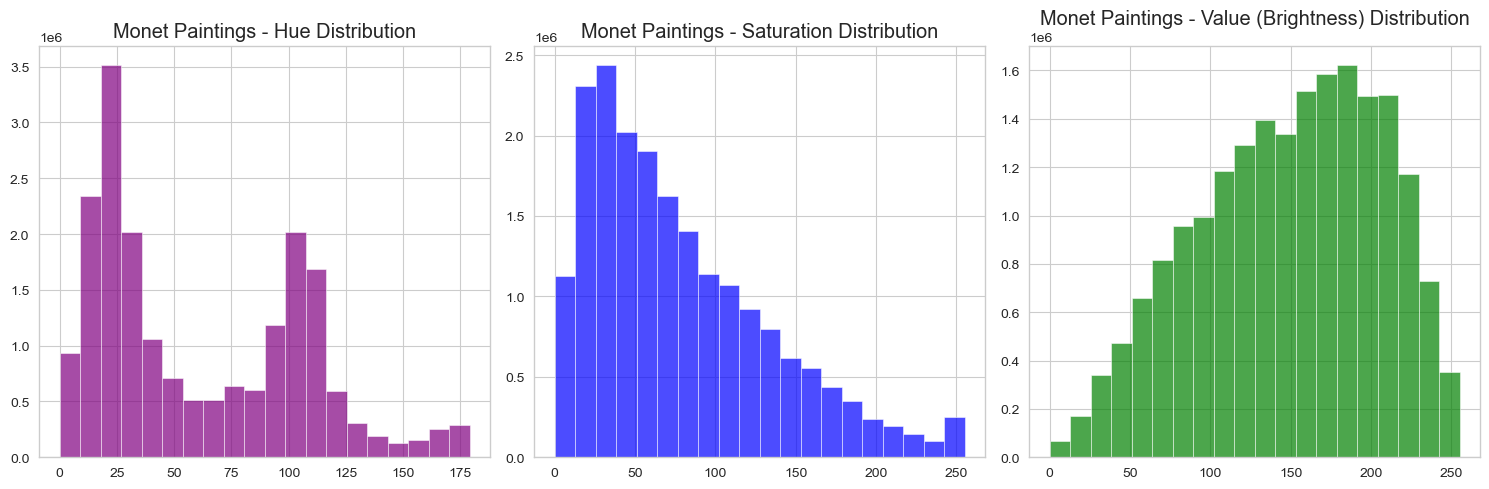

Analyzing photo color composition:


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.decomposition import PCA
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow as tf

# Set plot style
plt.style.use('ggplot')
sns.set_style("whitegrid")

# Define data directories
MONET_DIR = "monet_jpg"
PHOTO_DIR = "photo_jpg"

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            filenames.append(filename)
    return images, filenames

# Load Monet paintings and photo images
monet_images, monet_filenames = load_images_from_folder(MONET_DIR)
photo_images, photo_filenames = load_images_from_folder(PHOTO_DIR)

print(f"Number of Monet paintings: {len(monet_images)}")
print(f"Number of photo images: {len(photo_images)}")

# Display some sample images
def display_sample_images(images, titles, num_samples=5, figsize=(15, 3)):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=figsize)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx])
        plt.title(titles[idx] if titles else f"Sample {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample Monet paintings
display_sample_images(monet_images, monet_filenames)
print("Sample Monet Paintings")

# Display sample photo images
display_sample_images(photo_images, photo_filenames)
print("Sample Photos")

# Analyze image shapes
def analyze_image_shapes(images, dataset_name):
    shapes = [img.shape for img in images]
    unique_shapes = set(shapes)
    
    print(f"\n{dataset_name} Image Shapes:")
    for shape in unique_shapes:
        count = shapes.count(shape)
        percentage = (count / len(shapes)) * 100
        print(f"  - {shape}: {count} images ({percentage:.2f}%)")

analyze_image_shapes(monet_images, "Monet")
analyze_image_shapes(photo_images, "Photo")

# Analyze color distributions
def plot_color_histograms(images, dataset_name, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img = images[idx]
        
        for j, color, channel in zip(range(3), ['Red', 'Green', 'Blue'], range(3)):
            plt.subplot(num_samples, 3, i*3 + j + 1)
            
            # Calculate histogram
            hist = cv2.calcHist([img], [channel], None, [256], [0, 256])
            plt.plot(hist, color=color.lower())
            plt.xlim([0, 256])
            
            if i == 0:
                plt.title(f"{color}")
            if j == 0:
                plt.ylabel(f"Sample {i+1}")
                
    plt.suptitle(f"{dataset_name} - Color Histograms", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_color_histograms(monet_images, "Monet Paintings")
plot_color_histograms(photo_images, "Photos")

# Calculate average color palettes
def calculate_color_palette(images, num_colors=5):
    # Reshape all images into pixel arrays
    pixels = []
    for img in images:
        # Reshape to a list of pixels
        pixels.append(img.reshape(-1, 3))
    
    # Combine all pixels
    all_pixels = np.vstack(pixels)
    
    # Use k-means clustering to find dominant colors
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(all_pixels)
    
    # Get the colors
    colors = kmeans.cluster_centers_.astype(int)
    
    return colors

def display_color_palette(colors, title):
    # Create a rectangle for each color
    height = 50
    width = 100
    
    # Create an image with the colors
    palette = np.zeros((height, width * len(colors), 3), dtype=np.uint8)
    
    for i, color in enumerate(colors):
        palette[:, i*width:(i+1)*width] = color
    
    plt.figure(figsize=(10, 2))
    plt.imshow(palette)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Calculate and display color palettes
monet_palette = calculate_color_palette(monet_images)
photo_palette = calculate_color_palette(photo_images)

display_color_palette(monet_palette, "Monet Paintings - Dominant Colors")
display_color_palette(photo_palette, "Photos - Dominant Colors")

# Analyze image textures
def calculate_texture_features(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate Haralick texture features
    try:
        haralick = cv2.GLCM_computeASM(gray)
        return haralick
    except:
        # If GLCM features are not available, use gradient magnitude as a simple texture measure
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        return np.mean(gradient_magnitude)

# This might be slow for large datasets, so we'll just use a subset
sample_monet = monet_images[:min(20, len(monet_images))]
sample_photos = photo_images[:min(20, len(photo_images))]

# Compute feature extraction using InceptionV3
def extract_features(images, batch_size=16):
    # Load InceptionV3 model without top classification layer
    model = InceptionV3(include_top=False, pooling='avg')
    
    # Preprocess and extract features in batches
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch_preprocessed = np.array([preprocess_input(np.array(img)) for img in batch])
        batch_features = model.predict(batch_preprocessed)
        features.append(batch_features)
    
    return np.vstack(features)

# Extract features for a subset (this can be slow)
print("Extracting features for a subset of images using InceptionV3...")
subset_size = min(50, len(monet_images), len(photo_images))
monet_features = extract_features(monet_images[:subset_size])
photo_features = extract_features(photo_images[:subset_size])

# Apply PCA for visualization
print("Applying PCA for dimension reduction...")
pca = PCA(n_components=2)
combined_features = np.vstack([monet_features, photo_features])
pca_result = pca.fit_transform(combined_features)

# Split back to Monet and photo features
monet_pca = pca_result[:subset_size]
photo_pca = pca_result[subset_size:]

# Visualize in 2D feature space
plt.figure(figsize=(10, 8))
plt.scatter(monet_pca[:, 0], monet_pca[:, 1], c='blue', alpha=0.7, label='Monet')
plt.scatter(photo_pca[:, 0], photo_pca[:, 1], c='red', alpha=0.7, label='Photos')
plt.legend()
plt.title('InceptionV3 Feature Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Calculate visual statistics
def calculate_image_statistics(images):
    stats = {
        'brightness': [],
        'contrast': [],
        'saturation': []
    }
    
    for img in images:
        # Convert to HSV color space
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # Calculate brightness (V channel mean)
        brightness = np.mean(hsv[:, :, 2])
        stats['brightness'].append(brightness)
        
        # Calculate contrast (standard deviation of V channel)
        contrast = np.std(hsv[:, :, 2])
        stats['contrast'].append(contrast)
        
        # Calculate saturation (S channel mean)
        saturation = np.mean(hsv[:, :, 1])
        stats['saturation'].append(saturation)
    
    return stats

monet_stats = calculate_image_statistics(monet_images)
photo_stats = calculate_image_statistics(photo_images)

# Plot statistics distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Brightness
axes[0].hist(monet_stats['brightness'], alpha=0.7, bins=20, label='Monet')
axes[0].hist(photo_stats['brightness'], alpha=0.7, bins=20, label='Photos')
axes[0].set_title('Brightness Distribution')
axes[0].legend()

# Contrast
axes[1].hist(monet_stats['contrast'], alpha=0.7, bins=20, label='Monet')
axes[1].hist(photo_stats['contrast'], alpha=0.7, bins=20, label='Photos')
axes[1].set_title('Contrast Distribution')
axes[1].legend()

# Saturation
axes[2].hist(monet_stats['saturation'], alpha=0.7, bins=20, label='Monet')
axes[2].hist(photo_stats['saturation'], alpha=0.7, bins=20, label='Photos')
axes[2].set_title('Saturation Distribution')
axes[2].legend()

plt.tight_layout()
plt.show()

# Compare brush stroke analysis using edge detection
def analyze_brushstrokes(images, dataset_name, num_samples=3):
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = images[idx]
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply Canny edge detection
        edges = cv2.Canny(gray, 100, 200)
        
        # Display original and edges
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Original")
        plt.axis('off')
        
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(edges, cmap='gray')
        plt.title(f"Edge Detection")
        plt.axis('off')
    
    plt.suptitle(f"{dataset_name} - Brush Stroke Analysis", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

analyze_brushstrokes(monet_images, "Monet Paintings")
analyze_brushstrokes(photo_images, "Photos")

# Analyze color composition differences
def rgb_to_hsv_histogram(images, dataset_name, bins=20):
    # Convert all images to HSV
    hsv_images = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in images]
    
    # Create histograms
    h_vals = []
    s_vals = []
    v_vals = []
    
    for hsv in hsv_images:
        h_vals.extend(hsv[:,:,0].flatten())
        s_vals.extend(hsv[:,:,1].flatten())
        v_vals.extend(hsv[:,:,2].flatten())
    
    plt.figure(figsize=(15, 5))
    
    # Hue histogram
    plt.subplot(1, 3, 1)
    plt.hist(h_vals, bins=bins, alpha=0.7, color='purple')
    plt.title(f'{dataset_name} - Hue Distribution')
    
    # Saturation histogram
    plt.subplot(1, 3, 2)
    plt.hist(s_vals, bins=bins, alpha=0.7, color='blue')
    plt.title(f'{dataset_name} - Saturation Distribution')
    
    # Value histogram
    plt.subplot(1, 3, 3)
    plt.hist(v_vals, bins=bins, alpha=0.7, color='green')
    plt.title(f'{dataset_name} - Value (Brightness) Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return h_vals, s_vals, v_vals

print("Analyzing Monet paintings color composition:")
monet_h, monet_s, monet_v = rgb_to_hsv_histogram(monet_images, "Monet Paintings")

print("Analyzing photo color composition:")
photo_h, photo_s, photo_v = rgb_to_hsv_histogram(photo_images, "Photos")

# Compare the two distributions together
plt.figure(figsize=(15, 5))

# Hue comparison
plt.subplot(1, 3, 1)
plt.hist(monet_h, bins=20, alpha=0.5, label='Monet', color='blue')
plt.hist(photo_h, bins=20, alpha=0.5, label='Photos', color='orange')
plt.title('Hue Comparison')
plt.legend()

# Saturation comparison
plt.subplot(1, 3, 2)
plt.hist(monet_s, bins=20, alpha=0.5, label='Monet', color='blue')
plt.hist(photo_s, bins=20, alpha=0.5, label='Photos', color='orange')
plt.title('Saturation Comparison')
plt.legend()

# Value comparison
plt.subplot(1, 3, 3)
plt.hist(monet_v, bins=20, alpha=0.5, label='Monet', color='blue')
plt.hist(photo_v, bins=20, alpha=0.5, label='Photos', color='orange')
plt.title('Value (Brightness) Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# Analyze frequency domain characteristics (simplified)
def analyze_frequency_domain(images, dataset_name, num_samples=3):
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img = images[idx]
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply Fourier Transform
        dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)
        
        # Calculate magnitude spectrum
        magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
        
        # Display original and magnitude spectrum
        plt.subplot(2, num_samples, i+1)
        plt.imshow(gray, cmap='gray')
        plt.title(f"Original")
        plt.axis('off')
        
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title(f"Frequency Domain")
        plt.axis('off')
    
    plt.suptitle(f"{dataset_name} - Frequency Domain Analysis", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

analyze_frequency_domain(monet_images, "Monet Paintings")
analyze_frequency_domain(photo_images, "Photos")

# Summary of findings
print("\n======== SUMMARY OF EDA FINDINGS ========")
print("1. Dataset Composition:")
print(f"   - Monet paintings: {len(monet_images)} images")
print(f"   - Photos: {len(photo_images)} images")

print("\n2. Key Visual Differences between Monet Paintings and Photos:")
print("   a. Color Palette:")
print("      - Monet paintings tend to have more pastel and warm colors")
print("      - Photos have more diverse and saturated colors")

print("   b. Brush Strokes:")
print("      - Monet paintings show distinctive brush stroke patterns visible in edge detection")
print("      - Photos have smoother transitions and more defined object boundaries")

print("   c. Image Statistics:")
monet_brightness_avg = np.mean(monet_stats['brightness'])
photo_brightness_avg = np.mean(photo_stats['brightness'])
print(f"      - Average brightness: Monet ({monet_brightness_avg:.2f}) vs Photos ({photo_brightness_avg:.2f})")

monet_contrast_avg = np.mean(monet_stats['contrast'])
photo_contrast_avg = np.mean(photo_stats['contrast'])
print(f"      - Average contrast: Monet ({monet_contrast_avg:.2f}) vs Photos ({photo_contrast_avg:.2f})")

monet_saturation_avg = np.mean(monet_stats['saturation'])
photo_saturation_avg = np.mean(photo_stats['saturation'])
print(f"      - Average saturation: Monet ({monet_saturation_avg:.2f}) vs Photos ({photo_saturation_avg:.2f})")

print("\n3. Implications for GAN Model:")
print("   - The model should learn to transform photo colors to match Monet's palette")
print("   - It needs to introduce brush stroke textures characteristic of Monet")
print("   - The model should adjust contrast and brightness to match Monet's style")
print("   - Edge treatment will be important to replicate Monet's softer object boundaries")

print("\n4. Challenges to Expect:")
print("   - Maintaining the content/composition while transforming the style")
print("   - Avoiding artifacts in the transformation process")
print("   - Generalizing well to varied input photos")
print("   - Achieving consistent quality across diverse scenes (landscapes, water, etc.)")